In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM

from scipy.stats import probplot
from scipy.stats import normaltest

from joblib import dump, load

from scipy import signal

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [2]:
def fft_from_vib(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
    amps /= 0.01
#     lin_amps = lin_log_interp(amps)
    return amps


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [3]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [4]:
trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train = fft_from_vib(X_train[:,:-1])[:,1:]
X_test = fft_from_vib(X_test[:,:-1])[:,1:]


X_train_healthy = X_train[first_good_train:,:]
X_valid_healthy = X_test[first_good_test:,:]
X_train_unhealthy = X_train[:first_good_train,:]
X_valid_unhealthy = X_test[:first_good_test,:]

np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)

num_samples = np.array([X_train_healthy.shape[0],
          X_valid_healthy.shape[0],
          X_train_unhealthy.shape[0],
          X_valid_unhealthy.shape[0]])

max_samples = np.amax(num_samples)

print(max_samples)
print(X_valid_healthy.shape[1])

X = []

X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)


columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']


156
2048


In [8]:
X[0].shape

(150, 2048)

In [61]:
estimators = [('reduce_dim', PCA(n_components=16)), ('gmm', GaussianMixture())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

fftPoints = 128

pipe = Pipeline(estimators)
pipe.fit(X_train_healthy[:,:fftPoints])


scores_gmm = []

scores_gmm = [np.zeros_like(X[i]) for i in range(len(X))]

for i in range(len(columns)):
    scores_gmm[i] = pipe.score_samples(X[i][:,:fftPoints])

In [62]:
def normalize_scores(scores,log_prob=False):

    flat = np.array([])
    for i in range(len(scores_gmm)):
        flat = np.append(flat,scores_gmm[i])
    
    max_val = np.amax(flat)
    
    if log_prob:
        scores = [np.log(np.abs(scores[i] - 1.1 * max_val)) for i in range(len(scores))]
    

    norm_mean = np.mean(scores[0])
    norm_std = np.std(scores[0])
    
    scores = [(scores[i] - norm_mean) / norm_std for i in range(len(scores))]
    
    [print(normaltest(scores[i])) for i in range(len(scores))]
    [print(np.std(scores[i]), np.mean(scores[i])) for i in range(len(scores))]
    
    return scores

In [63]:
test = np.array([])
for i in range(len(scores_gmm)):
    test = np.append(test,scores_gmm[i])
print(test.shape)
# [np.append(test,scores_gmm[i]) for i in range(len(scores_gmm))]

(457,)


NormaltestResult(statistic=7.87659708026488, pvalue=0.019481333269200173)
NormaltestResult(statistic=9.030738812616907, pvalue=0.01093956323665634)
NormaltestResult(statistic=42.212223711297646, pvalue=6.819178938043226e-10)
NormaltestResult(statistic=3.7761333801931722, pvalue=0.1513641599721341)
1.0 -3.848773152033876e-17
2.219091456538524 1.2317657630820944
1.3947147342763893 0.25577557749838276
1.0818653749026017 1.8545724999584705


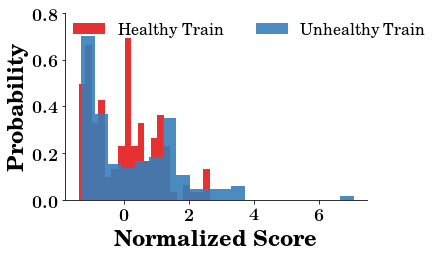

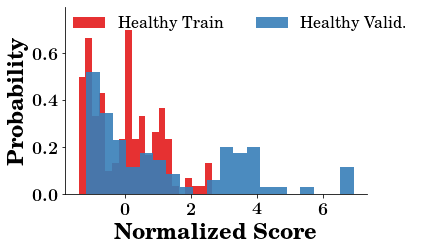

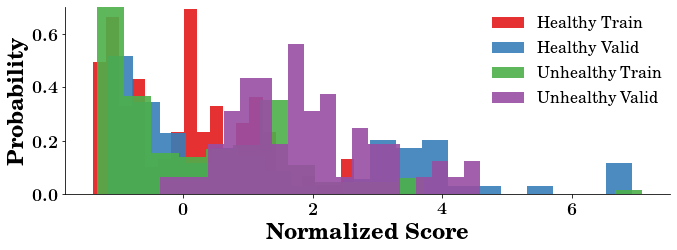

In [64]:
norm_scores_gmm = normalize_scores(scores_gmm,log_prob=True)

responses = [norm_scores_gmm[0],norm_scores_gmm[2]]
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.1,
               num_col=2)

responses = [norm_scores_gmm[0], norm_scores_gmm[1]]
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper left',
               ymax=0.1,
               num_col=2)

genplt.plot_histogram(norm_scores_gmm,columns,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_All',
               template='wide',
               ymax=0.0,
               num_col=1)


In [65]:
print(pipe['gmm'].covariances_.size)
print(pipe['gmm'].weights_.size)
print(pipe['gmm'].means_.size)

# dump(pipe, 'data/pca_gmm.joblib') 

256
1
16


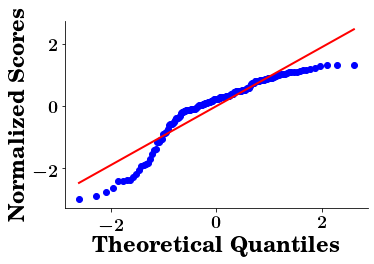

IndexError: list index out of range

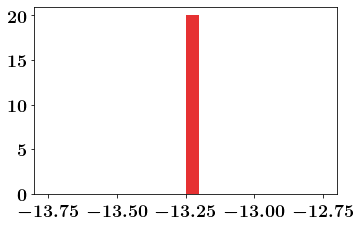

In [15]:
genplt.plot_normaltest(norm_scores_gmm[0],
                'Theoretical Quantiles',
                'Normalized Scores',
                'PCA-GMM_NormalTest')

genplt.plot_histogram(scores_gmm[0],[''],
               'Logarithmic Likelihood',
               'Probability',
               'PCA-GMM_Histogram_Train_Healthy',
               template='publication')

NormaltestResult(statistic=323.1021530657963, pvalue=6.906514313882521e-71)
NormaltestResult(statistic=100.01716573221057, pvalue=1.9122664847060877e-22)
NormaltestResult(statistic=330.47725424752906, pvalue=1.7289245569135768e-72)
NormaltestResult(statistic=129.25429690257442, pvalue=8.566157327572606e-29)
1.0000001 0.0
0.54278594 0.08334861
0.94175357 -0.0017995161
0.5116947 0.03301845
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 12)                9036      
_________________________________________________________________
sequential_4 (Sequential)    (None, 128)               9152      
Total params: 18,188
Trainable params: 18,188
Non-trainable params: 0
_________________________________________________________________
None


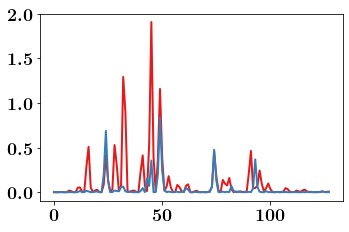

In [67]:
if os.path.isfile('data/AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/AE.h5')
    print(model.summary())
else:
    param_dict = {
        "hidden_nodes":[64,12],
        "input_shape":[fftPoints],
    }
    max_epochs = 20
    batch_size = 16
    verbose = 0

    model,encoder,decoder = create_vanilla_ae(param_dict)

    model.compile(loss='mean_squared_error', 
                  optimizer='adam')

    loss = model.fit(
                X[0][:,:fftPoints],X[0][:,:fftPoints],
                validation_split=0.2,
                epochs=max_epochs,
                batch_size=batch_size,
                verbose=verbose)
    
    
#     model.save('data/AE.h5',save_format='tf')

X_vanilla_ae = np.zeros_like(X)
mse_vanilla_ae = np.zeros_like(scores_gmm)

X_vanilla_ae = [np.array([]) for i in range(len(X))]
mse_vanilla_ae = [np.array([]) for i in range(len(X))]


for i in range(len(columns)):
    X_vanilla_ae[i] = model.predict(X[i][:,:fftPoints])
    mse_vanilla_ae[i] = keras.metrics.mean_squared_error(X_vanilla_ae[i],X[i][:,:fftPoints])

norm_vanilla_ae = normalize_scores(mse_vanilla_ae)

print(model.summary())

plt.plot(X[0][0,:fftPoints])
plt.plot(X_vanilla_ae[0][0,:])
plt.show()

In [27]:
len(norm_vanilla_ae)

4

In [30]:
model.predict(np.atleast_2d(X[0])).shape

(150, 2048)

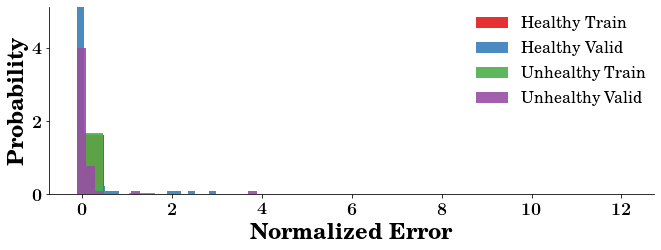

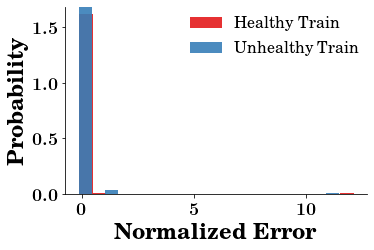

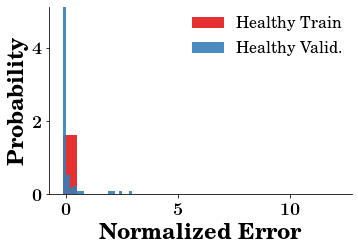

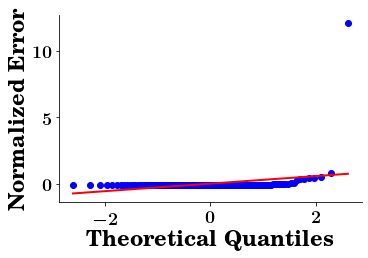

IndexError: list index out of range

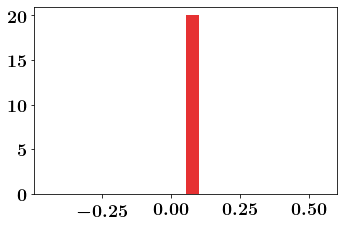

In [68]:
genplt.plot_histogram(norm_vanilla_ae,columns,
               'Normalized Error',
               'Probability',
               'AE_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = [norm_vanilla_ae[0],
                       norm_vanilla_ae[2]]
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = [norm_vanilla_ae[0],
                       norm_vanilla_ae[1]]
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'AE_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_vanilla_ae[0],
                'Theoretical Quantiles',
                'Normalized Error',
                'AE_NormalTest')

genplt.plot_histogram(mse_vanilla_ae[0],[''],
               'Mean Squared Error',
               'Probability',
               'AE_Histogram_Train_Healthy',
               template='publication')

In [59]:
import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_encoder(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape
                   ):
    
    encoder = Sequential()
    
    for i in range(len(filters)):
        if i == 0:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i],
                               input_shape=input_shape))
        else:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(0.5))
        encoder.add(MaxPooling1D(2))
        
    return encoder

def create_decoder(
                   filters,
                   kernels,
                   strides,
                   dilation_rates,
                   ):
    
    decoder = Sequential()
    
    filters.reverse()
    kernels.reverse()
    strides.reverse()
    dilation_rates.reverse()
    
    decoder.add(UpSampling1D(2))
    
    for i in range(1,len(filters)):
        decoder.add(Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i]))
#         decoder.add(Dropout(0.5))
        decoder.add(UpSampling1D(2))
    
    #decoder.add(Dropout_Live(0.5))
    decoder.add(Conv1D(1, 3, 1, activation='sigmoid', padding='same'))
    
    return decoder
    
def create_autoencoder(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
        
    encoder = create_encoder(filters,kernels,strides,dilation_rates,input_shape)
    decoder = create_decoder(filters,kernels,strides,dilation_rates)
    
    stacked_ae = Sequential([encoder, decoder])

    return stacked_ae,encoder,decoder
    

In [61]:
if os.path.isfile('data/CNN-AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-AE.h5')
    print(model.summary())
else:
    filters=[8,16,32]
    kernels = [3,3,3]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [2048,1]

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
    }

    model,encoder,decoder = create_autoencoder(param_dict)

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X[...,0,np.newaxis],X[...,0,np.newaxis],
                        epochs=30,batch_size=16,
                        validation_split=0.2,verbose=1,
    #                     validation_data=[X_healthy_test[...,np.newaxis],X_healthy_test[...,np.newaxis]]
                       )
    
#     model.save('data/CNN-AE.h5',save_format='tf')


# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# open(os.path.join('data', 'CNN-AE.tflite',),
#      "wb").write(tflite_model)

X_conv_ae = np.zeros_like(X)
mse_conv_ae = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_conv_ae[...,i] = np.squeeze(model.predict(X[...,i,np.newaxis]))
    mse_conv_ae[:,i] = keras.metrics.mean_squared_error(X_conv_ae[...,i],X[...,i])

norm_conv_ae = normalize_scores(mse_conv_ae)

Train on 124 samples, validate on 32 samples
Epoch 1/30
124/124 [==============================] - 4s 33ms/sample - loss: 0.0315 - val_loss: 0.0612
Epoch 2/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0195 - val_loss: 0.0616
Epoch 3/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0139 - val_loss: 0.0619
Epoch 4/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0109 - val_loss: 0.0616
Epoch 5/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0091 - val_loss: 0.0606
Epoch 6/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0078 - val_loss: 0.0598
Epoch 7/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0071 - val_loss: 0.0590
Epoch 8/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0065 - val_loss: 0.0587
Epoch 9/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0061 - val_loss: 0.0586
Epoch 10/30
124/124 [===============

In [62]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='data/CNN-AE.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)
    
    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]

    all_outputs = np.zeros((num_samples,output_shape[1],output_shape[2]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        

        all_outputs[i,...] = output_data
    
    return all_outputs


ValueError: Could not open 'data/CNN-AE.tflite'.

In [63]:
X_conv_ae_lite = np.zeros_like(X)
mse_conv_ae_lite = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_conv_ae_lite[...,i] = np.squeeze(tflite_inference(X[...,i],interpreter))
    mse_conv_ae_lite[:,i] = keras.metrics.mean_squared_error(X_conv_ae_lite[...,i],X[...,i])

norm_conv_ae_lite = normalize_scores(mse_conv_ae_lite)

NameError: name 'tflite_inference' is not defined

In [64]:
norm_conv_ae_lite.shape


NameError: name 'norm_conv_ae_lite' is not defined

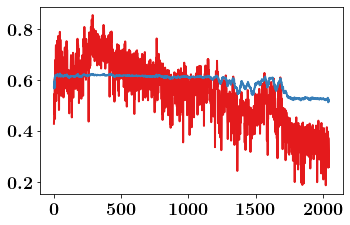

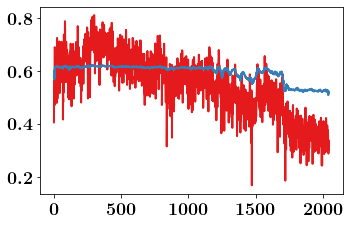

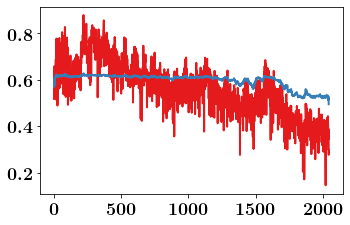

In [65]:
plt.plot(X[0,1:-1,0])
plt.plot(X_conv_ae[0,1:-2,0])
plt.show()


plt.plot(X[0,1:-1,1])
plt.plot(X_conv_ae[0,1:-2,1])
plt.show()


plt.plot(X[0,1:-1,2])
plt.plot(X_conv_ae[0,1:-2,2])
plt.show()


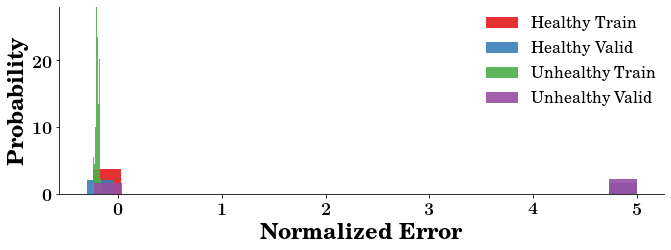

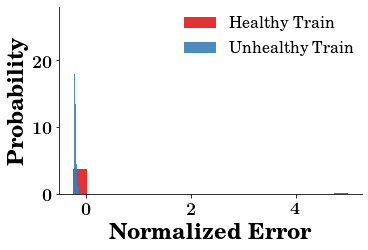

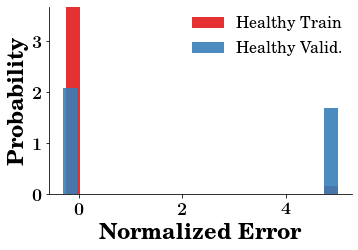

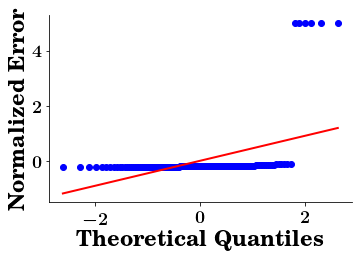

No handles with labels found to put in legend.


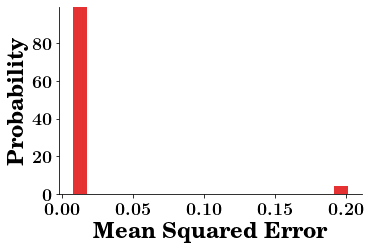

In [66]:
genplt.plot_histogram(norm_conv_ae,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE_NormalTest')

genplt.plot_histogram(mse_conv_ae[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE_Histogram_Train_Healthy',
               template='publication')

In [67]:
genplt.plot_histogram(norm_conv_ae_lite,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae_lite[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE-Lite_NormalTest')

genplt.plot_histogram(mse_conv_ae_lite[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE-Lite_Histogram_Train_Healthy',
               template='publication')

NameError: name 'norm_conv_ae_lite' is not defined

In [68]:
import tflite_runtime.interpreter as tflite

In [51]:
a = np.array([1,2,3,4,5,6])

In [52]:
a.shape

(6,)

In [54]:
np.atleast_2d(a).shape

(1, 6)